# Basic image reduction

When we point our telescope at a distant star or nebula and take a photograph using a camera, the light from the object is collected by the telescope and imaged on to the camera sensor, producing a "photograph" of the object in question. It might seem that this is the end product of astrophotography, but in fact it is just the beginning. The image obtained from the camera sensor has in it several artificial signatures added to it by both the camera as well as the optics. Consequently, the distribution of light that you see in the image is not a faithful representation of the actual object, but is in reality distorted. At the very least, this will result in visual artifacts when processing the image for astrophotography. More seriously, however, if you want to use your image to perform actual science by (say) counting the photons that arrive from two different stars and measuring their relative brightness, you would get unscientific results.

Thus, it is necessary to account for these signatures before using our images for scientific measurements. This process is known as _image reduction_. The images before this process are generally referred to as _raw images_ while the final processed images are called _science_ images.

We perform image reduction by taking three types of "calibration" frames -- darks, biases, and flats -- in addition to our raw images (which are called "lights"). Thus, we should have four different types of images in all:

1. **Lights**: Your "raw" images, which are usually long-exposure photos taken at a specific temperature and for a specific exposure time.
2. **Darks**: Images taken at the same exposure time and temperature as your lights, but with a black filter covering the sensor. Thus, darks do not include any details of the optics. These images measure the signal received by the sensor in the _absence_ of any input from the sky. As a result, these images include the effect of thermal noise on the sensor.
3. **Biases**: Images taken at the same temperature as the lights and the darks, and with a black filter covering the sensor, but taken at the lowest possible exposure time (say, 10 $\mu$s). These images measure the _readout_ noise: the noise that the sensor intrinsically produces, irrespective of  thermal noise.
5. **Flats**: Images taken with a uniform illumination (equal number of photons) over all the pixels. Given the intrinsic differences between pixels, despite the same number of photons being incident on the sensor, they may not all produce the same signal. To account for this, we take flats.



In [1]:
# The following lines are required so that the local ``astrolab`` package can be recognised by Python. 
# This is only necessary if you haven't installed the ``astrolab`` package on your machine.

import os
import sys
sys.path.insert(0, os.path.abspath("../../.."))

In [2]:
# Loading the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from astrolab import imaging as im

## Loading a single light frame

Let us begin by loading a single "raw" image that we wish to convert to a "science" image to extract data. The data of this image will be stored in a variable so that we can manipulate it later.

In the cell below, we load a single file from the "lights" folder using the ``load_image`` function from the ``astrolab.imaging`` module. We can then show the image using the ``display`` function from the same module.

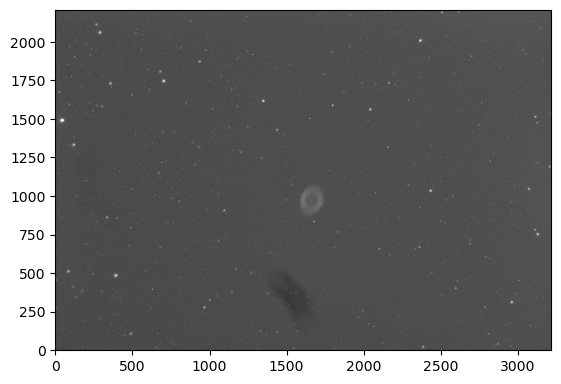

In [3]:
# Load a single image

unreduced = im.load_image("./data/imaging/ring/lights/ring-0001L.fit")

im.display(unreduced)
plt.show()

By default, ``imaging.display`` stretches the image in a log scale, so that the image will appear as it would to the human eye, more or less. While this looks good, it doesn't always allow us to see small variations in the image. However, it is precisely these small variations that we want to correct for.

Thus, the ``imaging.display`` function also has the option of using a "linear" stretch, but with a "percentile" cutoff. In this method, only pixels between the lower and upper percentile are displayed. While the image will not look as pretty, this has the advantage of showing minor variations in the pixel values, which will be useful for our tutorial. Let us now use this "percentile" stretch to visualise the image. 

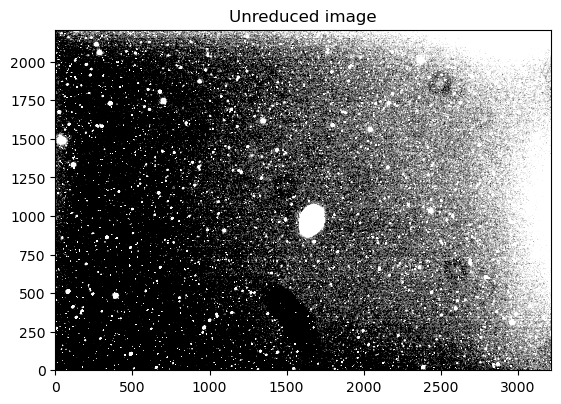

In [4]:
im.display(unreduced, title="Unreduced image", stretch='linear', min_percent=40, max_percent=80)


Notice in the image above that there is a gradient to the right and top. Additionally, two or three small "donuts" can be seen. The reason for both of these artifacts will become clear when we look at the calibration frames.

**Note:** A thick black smudge also exists immediately under the Ring. This is a result of a small accident during imaging, which we think is due to a droplet of water that condensed on the sensor window. Ideally, this should have been taken care of by the flat-frames. However, since we only took the flats the following day, the water had evaporated, and we can therefore not correct for it in these images. This highlights the importance of taking flats as soon as possible to accurately correct your image.

## Loading calibration frames

As mentioned above, in order to truly measure anything from this image, however, we will need to apply calibration frames to it to ensure that what we measure is meaningful. The three types of calibration images needed -- darks, biases, and flats -- are placed in appropriately named folders inside ``./data/imaging/ring/``. We will load the list of filenames for each of these sets of images, and then stack them together.

Almost all the functions in the ``astrolab`` package have a ``print_log`` option. When ``print_log=True``, it prints a small note (or produces a plot) that is intended to help you understand exactly what the function is doing, so that you can debug your code easily.

In [5]:
# Load the dark, bias, and flat file list

darkfiles = im.get_files("./data/imaging/ring/darks/*.fit", print_log=True)
biasfiles = im.get_files("./data/imaging/ring/biases/*.fit", print_log=True)
flatfiles = im.get_files("./data/imaging/ring/flats/*.fit", print_log=True)

Files loaded:
 ['./data/imaging/ring/darks/ring-0002D.fit'
 './data/imaging/ring/darks/ring-0003D.fit'
 './data/imaging/ring/darks/ring-0004D.fit'
 './data/imaging/ring/darks/ring-0005D.fit']
Files loaded:
 ['./data/imaging/ring/biases/ring-0002Bias.fit'
 './data/imaging/ring/biases/ring-0003Bias.fit'
 './data/imaging/ring/biases/ring-0004Bias.fit'
 './data/imaging/ring/biases/ring-0005Bias.fit']
Files loaded:
 ['./data/imaging/ring/flats/boxlight_flats_1-0011L.fit'
 './data/imaging/ring/flats/boxlight_flats_1-0012L.fit'
 './data/imaging/ring/flats/boxlight_flats_1-0013L.fit'
 './data/imaging/ring/flats/boxlight_flats_1-0014L.fit'
 './data/imaging/ring/flats/boxlight_flats_1-0015L.fit']


## Stacking the calibration frames

We take multiple calibration frames to account for statistical variations. As a result, we would like to average these different calibration frames pixel-by-pixel to produce "master" calibration frames. This can be done using the `stack_files` function from the `astrolab.imaging` module, which accepts a file-list and produces a single stacked array.


**Note:** We have not tried to stack multiple lights in the same way using the ``stack_files`` function. This is because the ``stack_files`` function simply adds up the images pixel-by-pixel. This works for calibration frames, since they only depend on individual pixel values (we are only interested in the response of every pixel). However, this will not work for lights, since if the telescope is not perfectly polar aligned, the image may "drift" over time. As a result, each "pixel" doesn't correspond to the same location in the sky, and so naively adding up pixel values will not give us anything meaningful. Thus, we must first reduce every image, and _then_ stack them. The process of stacking lights is covered in another tutorial.

In [6]:
# Creating master files for darks, biases, and flats

masterdark = im.stack_files(darkfiles)
masterbias = im.stack_files(biasfiles)
masterflat = im.stack_files(flatfiles)

We can now look at these different "master" calibration frames, aganin using the ``display`` function of the ``astrolab.imaging`` module. This function also allows you the option of sending in ``fig`` and ``ax`` parameters, which allow you to plot its results on a canvas that has already been created. This is particularly useful if you want to compare two or more results in either the same plot, or side-by-side, as we will do below.

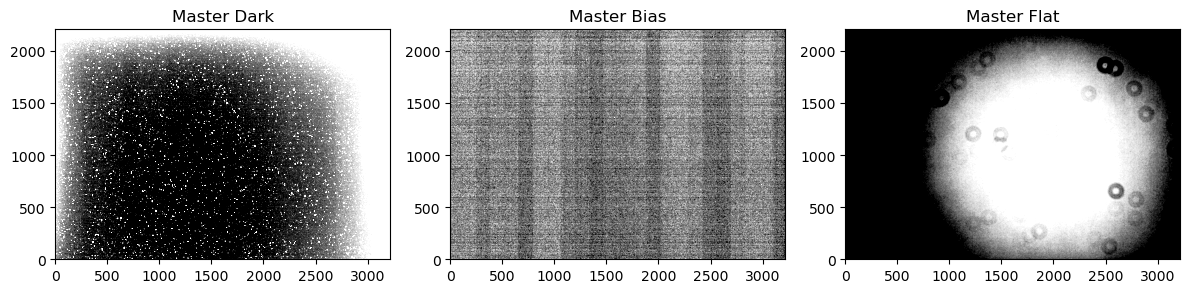

In [7]:
# Displaying the master calibration frames

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3)) # Create 3 subplots, and plot each calibration frame in each of them

im.display(masterdark, fig=fig, ax=axes[0], title="Master Dark", stretch='linear', min_percent=40, max_percent=80)
im.display(masterbias, fig=fig, ax=axes[1], title="Master Bias", stretch='linear', min_percent=40, max_percent=80)
im.display(masterflat, fig=fig, ax=axes[2], title="Master Flat", stretch='linear', min_percent=40, max_percent=80)
plt.tight_layout()

In the above results, keep in mind that the parts that are dark are not strictly "zero signal", we have just upped the contrast using the "percentile" stretching so that small variations are noticeable.

Looking at the images, you should also be able to see that the dark frame has an overall gradient towards the right and top, the bias frame has a characteristic "zebra" pattern, and the flat frame shows that a roughly circular region, slightly offset from the centre of the sensor, is more "sensitive" than the rest of the sensor. All of these effects are due to the sensor and the optics, and have no real bearing on the actual object we are imaging. However, our "raw" image has all these effects in it, and we must therefore account for them.

**Note:** In the flats, you should also notice some very clear "donut" shapes, just like in our "raw" image. These "donuts" are "[Airy Disks](https://en.wikipedia.org/wiki/Airy_disk)": diffraction patterns due to tiny grains of dust on the sensor and the filters. As you may imagine, these can severely affect the quality of our image! Thankfully, the process of image-reduction also accounts for them. However, since the location of dust particles could vary from filter to filter, we need separate calibration frames when we reduce images for _each_ filter. Additionally, dust can appear or disappear, meaning that we regularly need to retake flats.

## Reducing the image

The image is reduced using the formula
\begin{equation}
\mathrm{reduced\,\,image} = \frac{\mathrm{light} - \mathrm{dark}}{\mathrm{flat} - \mathrm{bias}}.
\end{equation}

In this formula, we are subtracting the dark from the light, and then scaling the overall image by the contribution of the flat. Of course, the overall pixel values of the flat might be quite high, and so it is often nice to use a _normalised_ denominator, i.e.
\begin{equation}
\mathrm{normalised\,\,denominator} = \frac{\mathrm{flat} - \mathrm{bias}}{\mathrm{avg}({\mathrm{flat} - \mathrm{bias}})}.
\end{equation}

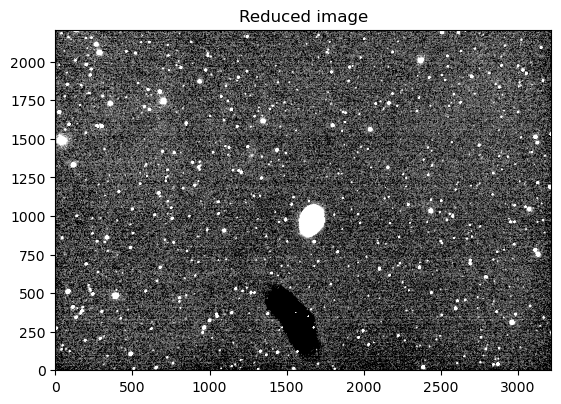

In [8]:
# Reducing the image

normalised_denominator = (masterflat-masterbias)/np.mean(masterflat-masterbias)

reduced = (unreduced - masterdark)/normalised_denominator

im.display(reduced, title="Reduced image", stretch='linear', min_percent=40, max_percent=80)

Clearly, the gradient has disappeared, as have the Airy disks. To compare, in the cell below we plot both the unreduced and the reduced images side by side. Notice that the "black smudge" continues to remain, since none of our calibration frames could get rid of it.

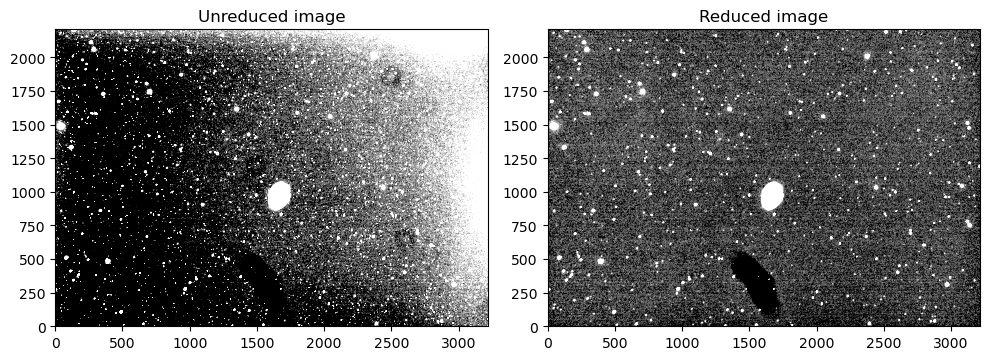

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].set_title("Unreduced image")
im.display(unreduced, fig=fig, ax=axes[0], stretch='linear', cmap="Greys_r", log_a=1000, min_percent=40, max_percent=80)

axes[1].set_title("Reduced image")
im.display(reduced, fig=fig, ax=axes[1], cmap="Greys_r", stretch='linear', min_percent=40, max_percent=80)

plt.tight_layout()